<a href="https://colab.research.google.com/github/OlegDze/public/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B3%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%B4%D0%BE%D1%80%D0%BE%D0%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Прогнозирование загруженности дорог

### Постановка задачи

Необходимо научиться делать почасовой прогноз загруженности дорог на 7 дней вперёд. Сначала без учёта данных о погоде, затем - с учётом. А также оценить влияние погоды на загруженность.

Для обучения будем использовать данные от Яндекса о загруженности дорог и погоде в период с 20 октября по 19 декабря 2021 года. Для прогнозирования воспользуемся библиотекой fbprophet. 

Оценивать качество модели будем с помощью кросс-валидации: сделаем 3 прогноза по 7 дней. Метрика качества - абсолютная ошибка MAE (mean absolute error).

### Загрузка данных о пробках

Загрузим необходимые библиотеки:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import datetime as dt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from google.colab import files

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Загрузим данные о пробках:

In [ ]:
uploaded = files.upload()

Saving пробки.xlsx to пробки.xlsx


In [ ]:
jams = pd.read_excel('пробки.xlsx')
jams.head()

,day,hour_,jams
0,2021-10-20,0,0
1,2021-10-20,1,0
2,2021-10-20,2,1
3,2021-10-20,3,1
4,2021-10-20,4,0


In [ ]:
jams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     1464 non-null   object
 1   hour_   1464 non-null   int64 
 2   jams    1464 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 34.4+ KB


В таблице 1464 строки и 3 столбца:
- day - дата;
- hour_ - час;
- jams - максимальный балл загруженности.

Пропусков в данных нет, они были предобработаны заранее с помощью excel.

Приведём данные к нужному виду, чтобы с ними было удобнее работать:

In [ ]:
# объединим дату и время в один столбец и преобразуем в тип данных datetime
jams['hour_'] = jams['hour_'].astype('str')
jams['ds'] = jams['day'] + ' ' + jams['hour_'] + ':00:00'
jams['ds'] = pd.to_datetime(jams['ds'])
# удалим ненужный столбец с датой и столбец с часом
jams.drop('day', axis=1, inplace=True)
jams.drop('hour_', axis=1, inplace=True)
# переименуем названия оставшихся столбцов согласно требованиям fbprophet
jams.columns = ['y', 'ds']

Выведем первые 5 записей и посмотрим на типы данных в столбцах:


In [ ]:
jams.head(5)

,y,ds
0,0,2021-10-20 00:00:00
1,0,2021-10-20 01:00:00
2,1,2021-10-20 02:00:00
3,1,2021-10-20 03:00:00
4,0,2021-10-20 04:00:00


In [ ]:
jams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       1464 non-null   int64         
 1   ds      1464 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 23.0 KB


Осталось два нужных нам столбца: балл загруженности, дата и время.

Построим график загруженности:

In [ ]:
fig = px.line(jams, x='ds', y='y', title='Динамика загруженности дорог по часам с 20 октября по 19 декабря 2021 года', width=1300, height=400
              , labels={'ds': 'Дата и время', 'y': 'Загруженность, балл'})
fig.show()

Построим гистограмму загруженности и посмотрим, какой балл встречается наиболее часто:

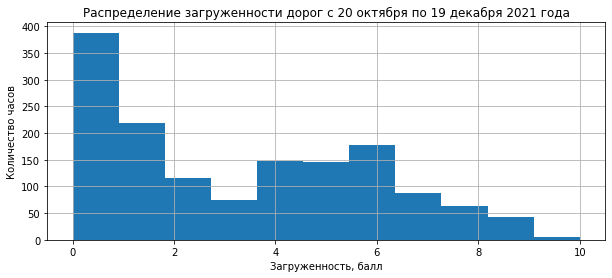

In [ ]:
jams['y'].hist(bins=11, figsize=(10, 4))
plt.title("Распределение загруженности дорог с 20 октября по 19 декабря 2021 года") 
plt.xlabel("Загруженность, балл")
plt.ylabel("Количество часов") 
plt.show()

Наиболее часто дороги свободны (0-1 балла) - это ночь, люди спят. Также часто загруженность составляет 4-6 баллов - это середина дня в будние, между утренним и вечерним часами-пик, а также весь день в выходные. Относительно редко загруженность поднимается до 8-10 баллов - это часы-пик в будние.

### Прогноз загруженности без учёта данных о погоде

#### Обучение модели

Составим список праздников и дней локдауна в период с 20 октября по 19 декабря:

In [ ]:
holidays = pd.DataFrame({'holiday': 'holiday'
                       , 'ds': pd.to_datetime(['2021-10-28', '2021-10-29', '2021-10-30', '2021-10-31', '2021-11-01'
                                             , '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06'
                                             , '2021-11-07'])})

Создадим модель и обучим её:

In [ ]:
m = Prophet(daily_seasonality=False # отключим дневную сезонность, т.к. графики загруженности для выходных и рабочих отличаются
            , weekly_seasonality=30 # задаём плавность компоненты недельной сезонности
            , holidays=holidays # добавим информацию о праздниках и днях локдауна
            , seasonality_mode='multiplicative') # используем мультипликативную модель
m.fit(jams)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Сделаем прогноз загруженности для периода, на котором обучались:

In [ ]:
forecast = m.predict(jams[['ds']])

Построим график, где точками отмечены фактические данные о загруженности и линией - прогнозные:

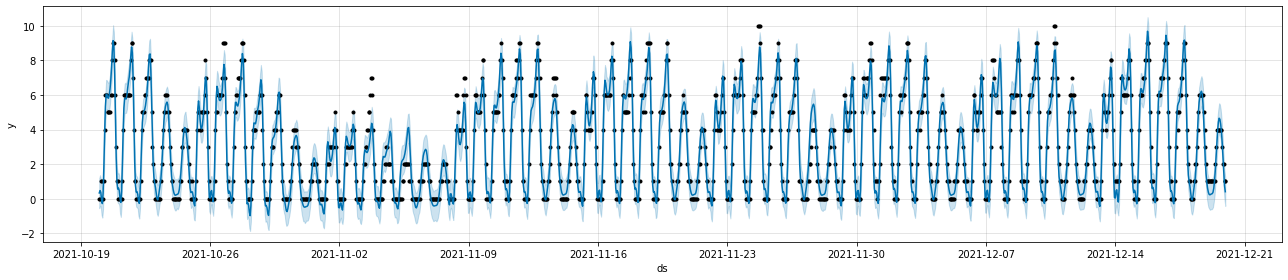

In [ ]:
fig1 = m.plot(forecast, figsize=(18, 4))

Разложим прогноз на компоненты:

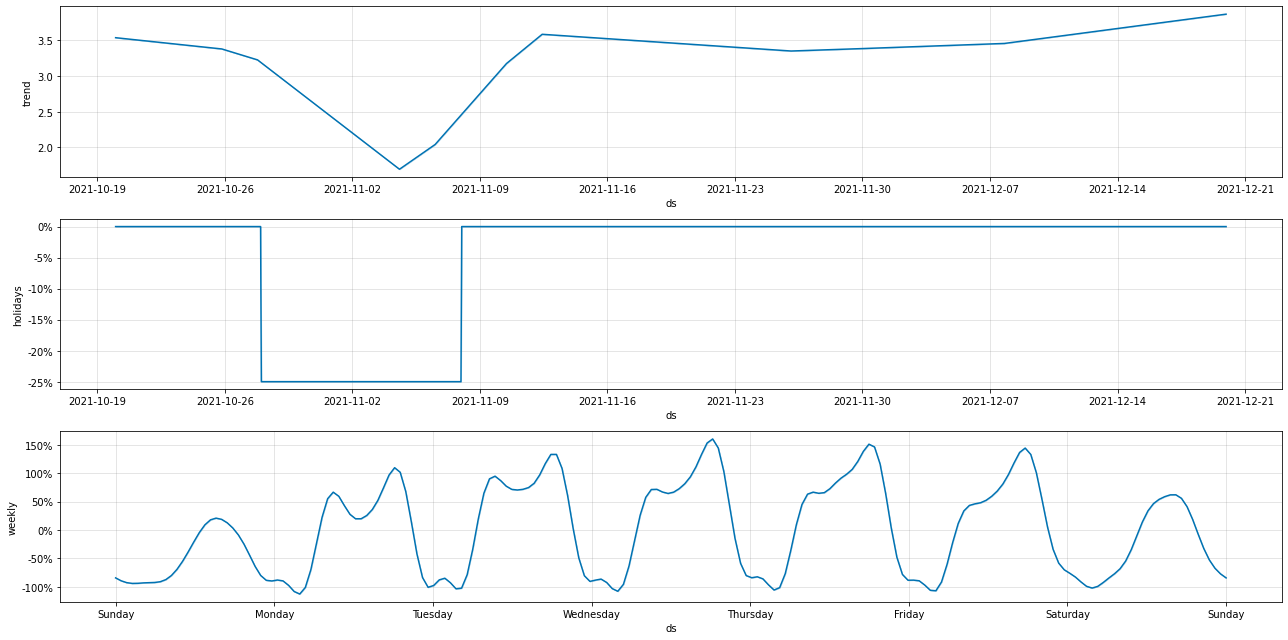

In [ ]:
fig2 = m.plot_components(forecast, figsize=(18, 9))

На недельной компоненте хорошо заметны "одногорбые" выходные и "двугорбые" рабочие дни с утренним и вечерним часами-пик.

#### Кросс-валидация

Для оценки качества обученной модели сделаем кросс-валидацию. Составим 3 прогноза по 7 дней, начиная со следующих дат и времени (невключительно):

In [ ]:
cutoffs = pd.to_datetime(['2021-11-28 23:00:00', '2021-12-05 23:00:00', '2021-12-12 23:00:00'])

Каждый из трёх прогнозов будет строиться исходя из данных загруженности только за предыдущие дни. 

Выведем таблицу с результатами:

In [ ]:
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='7 days')
df_cv[['ds', 'yhat', 'y', 'cutoff']].head()

  0%|          | 0/3 [00:00<?, ?it/s]

,ds,yhat,y,cutoff
0,2021-11-29 00:00:00,0.276244,0,2021-11-28 23:00:00
1,2021-11-29 01:00:00,0.357863,0,2021-11-28 23:00:00
2,2021-11-29 02:00:00,0.183102,0,2021-11-28 23:00:00
3,2021-11-29 03:00:00,-0.207380,0,2021-11-28 23:00:00
4,2021-11-29 04:00:00,-0.357501,0,2021-11-28 23:00:00


Ограничим прогноз загруженности 10 баллами сверху и 0 баллами снизу, напишем функцию:

In [ ]:
def foo(yhat):
  if yhat > 10:
    return 10
  elif yhat < 0:
    return 0
  else:
    return yhat

Применим ограничение:

In [ ]:
df_cv['yhat'] = df_cv['yhat'].apply(foo)

Также округлим значения загруженности до целых:

In [ ]:
df_cv['yhat'] = round(df_cv['yhat'])

Построим графики, чтобы оценить точность трёх прогнозов визуально. Так как периоды прогноза идут один за другим, то выведем результаты на одном графике:

In [ ]:
fact = go.Scatter(x=df_cv['ds'], y=df_cv['y'], name='fact')
predict = go.Scatter(x=df_cv['ds'], y=df_cv['yhat'], name='predict')
data = [fact, predict]
fig = go.Figure(data=data)
fig.update_layout(width=1300, height=400
                  , title='Фактическая и прогнозируемая загруженность дорог по часам с 29 ноября по 19 декабря 2021 года (без учёта данных о погоде)')
fig.show()

Посчитаем ошибку для каждого часа прогноза:

In [ ]:
df_cv['error'] = df_cv['yhat'] - df_cv['y']
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,error
0,2021-11-29 00:00:00,0.0,-0.531315,1.100189,0,2021-11-28 23:00:00,0.0
1,2021-11-29 01:00:00,0.0,-0.454814,1.208547,0,2021-11-28 23:00:00,0.0
2,2021-11-29 02:00:00,0.0,-0.664563,0.983424,0,2021-11-28 23:00:00,0.0
3,2021-11-29 03:00:00,0.0,-0.921858,0.534011,0,2021-11-28 23:00:00,0.0
4,2021-11-29 04:00:00,0.0,-1.141332,0.488416,0,2021-11-28 23:00:00,0.0


Построим график ошибок во времени:

In [ ]:
fig = px.line(df_cv, x='ds', y='error', title='Динамика ошибок прогноза по часам с 29 ноября по 19 декабря 2021 года (без учёта данных о погоде)'
              , width=1300, height=400, labels={'ds': 'Дата и время', 'error': 'Ошибка, балл'})
fig.show()

Ошибка стабильна и колеблется в основном в диапазоне +-1 балл. Сильный выброс, равный 4 баллам, наблюдался один раз - 7 декабря с 18:00 до 20:00.

Построим гистограмму ошибок:

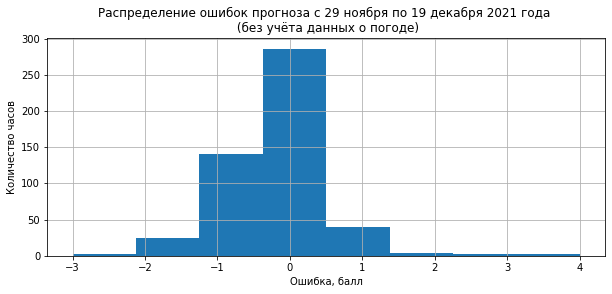

In [ ]:
df_cv['error'].hist(bins=8, figsize=(10, 4))
plt.title("Распределение ошибок прогноза с 29 ноября по 19 декабря 2021 года \n (без учёта данных о погоде)") 
plt.xlabel("Ошибка, балл")
plt.ylabel("Количество часов") 
plt.show()

Оценим среднее и стандартное отклонение распределения:

In [ ]:
df_cv['error'].mean(), np.std(df_cv['error'])

(-0.26587301587301587, 0.8385231441290689)

Распределение смещено в сторону отрицательных чисел - это видно по гистограммее и среднему. Это означает, что в среднем модель немного занижает загруженность.

Посчитаем абсолютную ошибку MAE (mean absolute error):

In [ ]:
abs(df_cv['error']).mean()

0.5277777777777778

Модель в среднем ошибалась на 0,5 балла каждый час.

### Загрузка данных о погоде

Загрузим данные:

In [ ]:
uploaded = files.upload()

Saving погода.xlsx to погода.xlsx


In [ ]:
weather = pd.read_excel('погода.xlsx')
weather.head()

,date_,hour_,temp,cloudness,prec_strength
0,2021-10-20,0,2.5,1.00,0.0
1,2021-10-20,1,3.0,1.00,0.0
2,2021-10-20,2,3.0,1.00,0.0
3,2021-10-20,3,2.0,0.94,0.0
4,2021-10-20,4,2.0,0.88,0.0


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_          1464 non-null   object 
 1   hour_          1464 non-null   int64  
 2   temp           1464 non-null   float64
 3   cloudness      1464 non-null   float64
 4   prec_strength  1464 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 57.3+ KB


В таблице 1464 строки и 5 столбцов:
- date - дата;
- hour_ - час;
- temp - средняя температура;
- cloudness - средняя облачность;
- prec_strength - максимальная сиал осадков.

Пропусков в данных нет, они были предобработаны заранее с помощью excel.

Приведём данные к нужному виду, чтобы с ними было удобнее работать:

In [ ]:
# объединим дату и время в один столбец и преобразуем в тип данных datetime
weather['hour_'] = weather['hour_'].astype('str')
weather['ds'] = weather['date_'] + ' ' + weather['hour_'] + ':00:00'
weather['ds'] = pd.to_datetime(weather['ds'])
# удалим ненужный столбец с датой и столбец с часом
weather.drop('date_', axis=1, inplace=True)
weather.drop('hour_', axis=1, inplace=True)
# переименуем названия оставшихся столбцов
weather.columns = ['temp', 'cloudness', 'prec_strength', 'ds']

Выведем первые 5 записей:

In [ ]:
weather.head()

,temp,cloudness,prec_strength,ds
0,2.5,1.00,0.0,2021-10-20 00:00:00
1,3.0,1.00,0.0,2021-10-20 01:00:00
2,3.0,1.00,0.0,2021-10-20 02:00:00
3,2.0,0.94,0.0,2021-10-20 03:00:00
4,2.0,0.88,0.0,2021-10-20 04:00:00


Остались четыре нужных нам столбца: температура, облачность, сила осадков, дата и время.

Построим график для температуры:

In [ ]:
fig = px.line(weather, x='ds', y='temp', title='Изменение температуры по часам с 20 октября по 19 декабря 2021 года', width=1300, height=400
              , labels={'ds': 'Дата и время', 'temp': 'температура, С'})
fig.show()

Построим график для облачности:

In [ ]:
fig = px.line(weather, x='ds', y='cloudness', title='Изменение облачности по часам с 20 октября по 19 декабря 2021 года', width=1300, height=400
              , labels={'ds': 'Дата и время', 'cloudness': 'Облачность, доля'})
fig.show()

Построим график для силы осадков:

In [ ]:
fig = px.line(weather, x='ds', y='prec_strength', title='Изменение силы осадков по часам с 20 октября по 19 декабря 2021 года', width=1300, height=400
              , labels={'ds': 'Дата и время', 'prec_strength': 'Сила осадков, уровень'})
fig.show()

Объединим таблицы с пробками и погодой:

In [ ]:
jams_weather = jams.merge(weather, how = 'inner', left_on='ds', right_on='ds')
jams_weather.head()

,y,ds,temp,cloudness,prec_strength
0,0,2021-10-20 00:00:00,2.5,1.00,0.0
1,0,2021-10-20 01:00:00,3.0,1.00,0.0
2,1,2021-10-20 02:00:00,3.0,1.00,0.0
3,1,2021-10-20 03:00:00,2.0,0.94,0.0
4,0,2021-10-20 04:00:00,2.0,0.88,0.0


### Прогноз загруженности с учётом данных о погоде

#### Обучение модели

Создадим модель с учётом данных о погоде и обучим её:

In [ ]:
m2 = Prophet(daily_seasonality=False, weekly_seasonality=30, holidays=holidays, seasonality_mode='multiplicative')
m2.add_regressor('temp', prior_scale=10, mode='multiplicative')
m2.add_regressor('cloudness', prior_scale=10, mode='multiplicative')
m2.add_regressor('prec_strength', prior_scale=10, mode='multiplicative')
m2.fit(jams_weather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Сделаем прогноз загруженности для периода, на котором обучались:

In [ ]:
forecast2 = m2.predict(jams_weather[['ds', 'temp', 'cloudness', 'prec_strength']])

Построим график, где точками отмечены фактические данные о загруженности и линией - прогнозные:

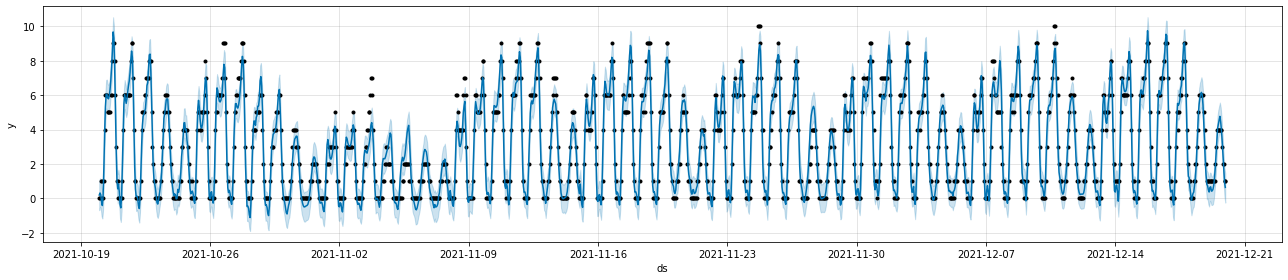

In [ ]:
fig1 = m2.plot(forecast2, figsize=(18, 4))

Разложим прогноз на компоненты:

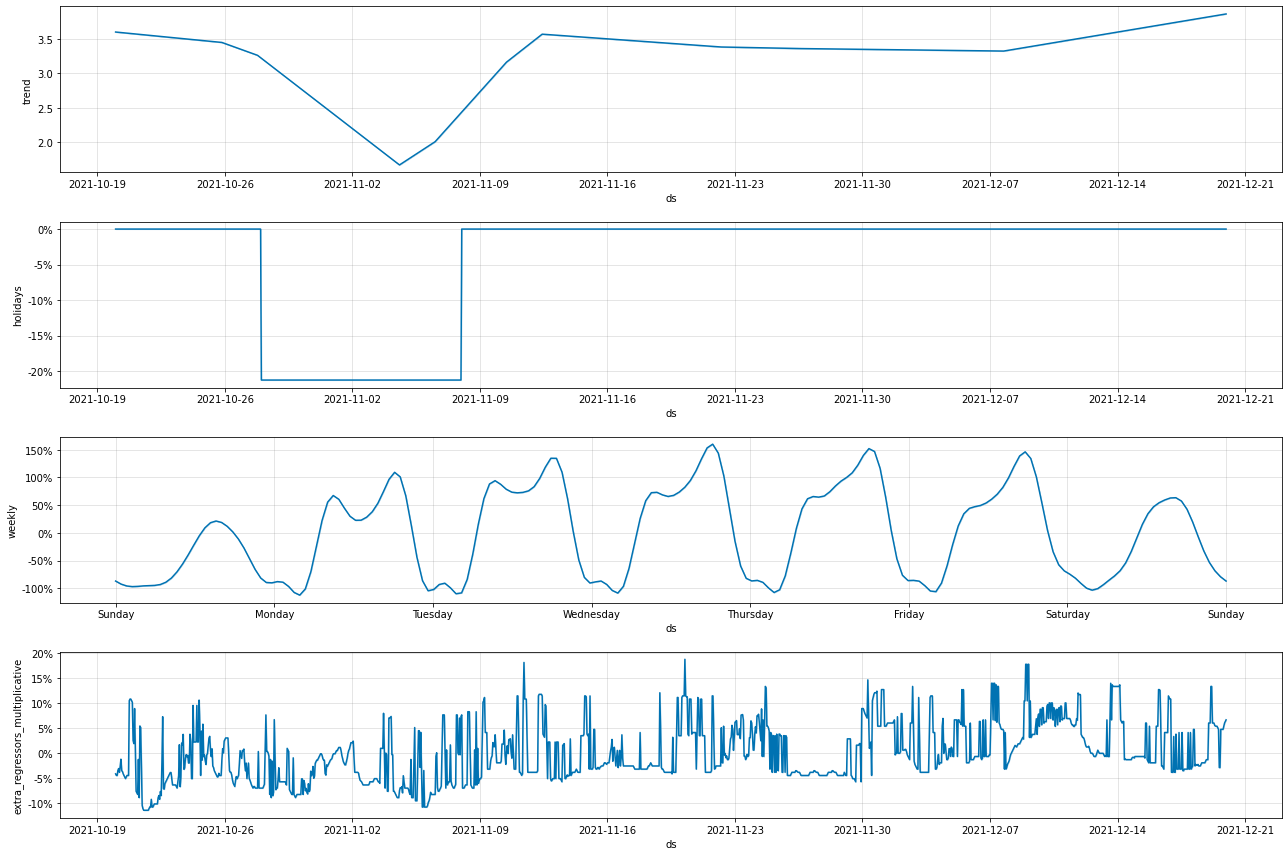

In [ ]:
fig2 = m2.plot_components(forecast2, figsize=(18, 12))

Появилась новая компонента - совокупная поправка на погоду.

#### Кросс-валидация

Кросс-валидацию проведём аналогично: составим 3 прогноза по 7 дней, начиная с тех же дат.

Выведем таблицу с результатами:

In [ ]:
df_cv2 = cross_validation(m2, cutoffs=cutoffs, horizon='7 days')
df_cv2[['ds', 'yhat', 'y', 'cutoff']].head()

  0%|          | 0/3 [00:00<?, ?it/s]

,ds,yhat,y,cutoff
0,2021-11-29 00:00:00,0.188206,0,2021-11-28 23:00:00
1,2021-11-29 01:00:00,0.302626,0,2021-11-28 23:00:00
2,2021-11-29 02:00:00,0.175396,0,2021-11-28 23:00:00
3,2021-11-29 03:00:00,-0.186677,0,2021-11-28 23:00:00
4,2021-11-29 04:00:00,-0.062614,0,2021-11-28 23:00:00


Ограничим загруженность 10 баллами сверху и 0 баллами снизу. Также округлим значения загруженности до целых:

In [ ]:
df_cv2['yhat'] = df_cv2['yhat'].apply(foo)
df_cv2['yhat'] = round(df_cv2['yhat'])

Построим график, чтобы оценить точность трёх прогнозов визуально:

In [ ]:
fact = go.Scatter(x=df_cv2['ds'], y=df_cv2['y'], name='fact')
predict = go.Scatter(x=df_cv2['ds'], y=df_cv2['yhat'], name='predict')
data = [fact, predict]
fig = go.Figure(data=data)
fig.update_layout(width=1300, height=400
                  , title='Фактическая и прогнозируемая загруженность дорог по часам с 29 ноября по 19 декабря 2021 года (с учётом данных о погоде)')
fig.show()

Посчитаем ошибку для каждого часа прогноза и построим график ошибок во времени:

In [ ]:
df_cv2['error'] = df_cv2['yhat'] - df_cv2['y']
fig = px.line(df_cv2, x='ds', y='error', title='Динамика ошибок прогноза по часам с 29 ноября по 19 декабря 2021 года (с учётом данных о погоде)'
              , width=1300, height=400, labels={'ds': 'Дата и время', 'error': 'Ошибка, балл'})
fig.show()

Ошибка стабильна. Выброс 7 декабря сохранился.

Построим гистограмму ошибок:

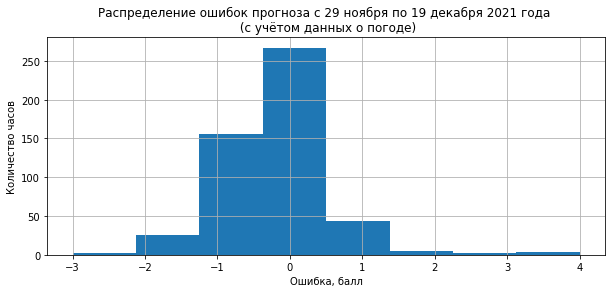

In [ ]:
df_cv2['error'].hist(bins=8, figsize=(10, 4))
plt.title("Распределение ошибок прогноза с 29 ноября по 19 декабря 2021 года \n (с учётом данных о погоде)") 
plt.xlabel("Ошибка, балл")
plt.ylabel("Количество часов") 
plt.show()

Распределение по-прежнему смещено влево: модель занижает загруженность.

Оценим среднее и стандартное отклонение распределения:

In [ ]:
df_cv2['error'].mean(), np.std(df_cv2['error'])

(-0.2837301587301587, 0.8526645762353694)

Среднее и стандартное отклонение ошибок практически такое же, как у модели без учёта погоды.

Посчитаем абсолютную ошибку MAE (mean absolute error):

In [ ]:
abs(df_cv2['error']).mean()

0.5654761904761905

MAE также практически не изменилось.

## Вывод

На интервале времени с 20 октября по 19 декабря 2021 не удалось выявить взаимосвязь между загруженностью дорог и погодой, которая бы позволила улучшить качество прогноза. Средняя абсолютная ошибка модели без учёта данных о погоде и модели с учётом одинаковая и составляет 0,5-0,6 балла. Это означает, что каждая из моделей в среднем ошибается на 0,5-0,6 балла для каждого часа. 